In [4]:
pip install torch_geometric

  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
KEY_CONFIG = {
    "atoms": "elements", 
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 원자 매핑 및 물리적 속성 (전기음성도, 공유결합 반지름, 발렌스 전자)
# H(1), C(6), N(7), O(8), F(9)
ATOM_PROPS = {
    1: [2.20, 0.31, 1.0], # H
    6: [2.55, 0.76, 4.0], # C
    7: [3.04, 0.71, 5.0], # N
    8: [3.44, 0.66, 6.0], # O
    9: [3.98, 0.57, 7.0]  # F
}
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

In [3]:
class ReactionDataset(Dataset):
    def __init__(self, h5_path, limit=None, transform=None, pre_transform=None):
        super(ReactionDataset, self).__init__(None, transform, pre_transform)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            atoms = group[KEY_CONFIG["atoms"]][()]
            
            # [물리 속성 추가] One-hot 대신 물리적 속성 벡터 사용 (또는 병합)
            # 여기서는 One-hot(5) + Prop(3) = 8차원 벡터 생성
            x_list = []
            for a in atoms:
                a_int = int(a)
                one_hot = [0]*5
                one_hot[ATOM_MAP.get(a_int, 0)] = 1
                props = ATOM_PROPS.get(a_int, [0, 0, 0])
                x_list.append(one_hot + props)
            
            x = torch.tensor(x_list, dtype=torch.float) # (N, 8)
            
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            y_delta = e_TS - e_R
            
            # [핵심] 반응 열역학 에너지 (Product - Reactant)
            # 이것이 BEP 원리를 모델에 알려주는 힌트가 됨
            thermo_energy = e_P - e_R 

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            edge_index = torch.stack([row[row!=col], col[row!=col]], dim=0)

            return Data(x=x, pos=pos_R, edge_index=edge_index, 
                        y_energy=y_delta, y_pos=pos_TS, 
                        thermo_energy=thermo_energy) # thermo_energy 전달

In [4]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        # 입력 차원 증가: One-hot(5) + Physics(3) = 8
        self.embedding = nn.Linear(node_dim, hidden_dim) 
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
        
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [5]:
class EdgeEnergyPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        
        # 1. Base Energy (Node)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # 2. Barrier Cost (Edge)
        edge_input_dim = (hidden_dim * 2) + 1 + 1 + 1 
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, edge_index, pos, gate_score, pred_delta_D, batch):
        row, col = edge_index
        
        # A. Base Energy
        h_graph = global_add_pool(h, batch)
        base_energy = self.node_mlp(h_graph)
        
        # B. Edge Barrier Energy
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist, pred_delta_D, gate_score], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat)
        
        # 반응 중심(Gate)에 비례하여 에너지 합산
        edge_contrib = edge_contrib * gate_score
        
        edge_batch = batch[row]
        barrier_energy = global_add_pool(edge_contrib, edge_batch)
        
        return base_energy + barrier_energy

In [6]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        message = self.message_mlp(edge_feat)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, message)
        new_h = self.update_mlp(torch.cat([h, aggr_msg], dim=-1))
        return self.norm(h + new_h)

In [7]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [8]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

In [9]:
class ThermodynamicsEnergyPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        
        # 1. Base Energy (Node-level)
        # 입력: Hidden + 3 (Thermo Energy)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # 2. Barrier Energy (Edge-level)
        # 입력 차원이 늘어납니다!
        # [h_i, h_j, dist_R, delta_D, gate, total_change_to_P]
        # total_change_to_P = |Dist_P - Dist_R| (구조가 결국 얼마나 변해야 하는가?)
        edge_input_dim = (hidden_dim * 2) + 1 + 1 + 1 + 1 
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy):
        """
        pos_R: 반응물 좌표
        pos_P: 생성물 좌표 (New Input!)
        """
        row, col = edge_index
        
        # --- Part A: Base Energy (BEP Principle) ---
        h_graph = global_add_pool(h, batch)
        # 반응 열역학 정보 결합
        combined_feat = torch.cat([h_graph, thermo_energy], dim=-1)
        base_energy = self.node_mlp(combined_feat)
        
        # --- Part B: Barrier Energy (Hammond's Postulate) ---
        # 1. 현재 결합 길이 (R)
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        
        # 2. 미래 결합 길이 (P) - 해먼드 가설 적용
        # "이 결합은 결국 나중에 어떻게 되는가?"
        # 생성물에서의 거리 계산
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # 3. 전체 구조 변화 요구량 (Total Geometric Demand)
        # 양수면 늘어나야 하고, 음수면 줄어들어야 함
        total_change_required = dist_P - dist_R
        
        # 4. 엣지 특징 조립
        # 모델에게 주는 정보:
        # "원자 특징(h) + 현재 거리(dist_R) + 지금 변한 정도(pred) + 중요도(gate) + **최종 목표 변화량(total_change)**"
        edge_feat = torch.cat([
            h[row], h[col], dist_R, pred_delta_D, gate_score, total_change_required
        ], dim=-1)
        
        # 5. 에너지 장벽 계산
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

In [10]:
class EnergyPredictor(nn.Module):
    """ 
    [핵심 수정] 구조 변화(Delta D) 정보를 입력받는 에너지 예측기 
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # 입력 차원 증가: hidden_dim(원래 특징) + 1(구조 변화량 스트레스)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim), 
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, edge_index, gate_score, batch, pred_delta_D):
        row, col = edge_index
        
        # 1. Edge의 구조 변화량(pred_delta_D)을 Node로 가져오기
        # "나에게 연결된 결합들이 얼마나 많이 변했는가?" (Total Distortion per Atom)
        distortion_per_node = torch.zeros(h.size(0), 1, device=h.device)
        
        # 변화량의 절대값을 더함 (늘어나든 줄어들든 에너지는 불안정해짐)
        distortion_per_node.index_add_(0, row, torch.abs(pred_delta_D) * gate_score) 
        
        # 2. Node Feature와 Distortion 정보 결합
        # 이제 모델은 "나는 탄소인데, 내 팔이 0.5옴스트롬 늘어났어!"라는 걸 알게 됨
        h_combined = torch.cat([h, distortion_per_node], dim=-1)
        
        # 3. 반응 중심 가중치(Gating) 적용 Pooling
        node_weight = torch.zeros(h.size(0), 1, device=h.device)
        node_weight.index_add_(0, row, gate_score)
        h_weighted = h_combined * torch.sigmoid(node_weight)
        
        # 4. 최종 예측
        return self.mlp(global_add_pool(h_weighted, batch))

In [11]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=8, hidden_dim=256, num_layers=4):
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = ThermodynamicsEnergyPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # [수정] pos_P (생성물 좌표)를 추가로 넘겨줌
        pred_delta_E3 = self.energy_predictor(
            h, 
            data.edge_index, 
            data.pos,       # pos_R
            data.pos_P,     # pos_P (New!)
            gate_map, 
            pred_delta_D, 
            data.batch, 
            data.thermo_energy
        )
        
        return pred_delta_D, pred_delta_E3, gate_map

In [12]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=5, hidden_dim=128, num_layers=3):
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        
        # [교체됨] 새로운 에너지 예측기 사용
        self.energy_predictor = EdgeEnergyPredictor(hidden_dim)

    def forward(self, data):
        # 1. Encoding
        h = self.encoder(data.x, data.pos, data.edge_index)
        
        # 2. Gating (반응 중심 찾기)
        gate_map = self.gating(h, data.edge_index, data.pos)
        
        # 3. 구조 변화 예측 (Delta D)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # 4. 에너지 예측 (Node 정보 + Edge 변화 정보 모두 사용)
        pred_delta_E3 = self.energy_predictor(
            h, 
            data.edge_index, 
            data.pos, 
            gate_map, 
            pred_delta_D, 
            data.batch
        )
        
        return pred_delta_D, pred_delta_E3, gate_map

In [13]:
def train(h5_path, epochs=30, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    dataset = ReactionDataset(h5_path, limit=limit)
    
    # 통계 계산 (정규화용)
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5
    for b in loader_stat:
        all_E.append(b.y_energy.view(-1, 3) * HARTREE_TO_KCAL)
    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Stats -> Mean: {y_mean.cpu().numpy()}, Std: {y_std.cpu().numpy()}")

    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    # node_dim=8 (물리 속성 포함)
    model = MultiEnergyModel(node_dim=8, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start Physics-Informed Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # 열역학 정보 단위 변환 (Hartree -> kcal/mol)
            # 입력값으로 들어가므로 너무 크지 않게 스케일링 (예: /100.0)
            # 또는 그냥 kcal/mol로 넣고 모델이 알아서 학습하게 둠 (LayerNorm이 처리함)
            batch.thermo_energy = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL
            
            pred_d, pred_e3, gate = model(batch)
            
            # Targets
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            delta_d_target = dist_TS - dist_R
            
            e_target_kcal = batch.y_energy.view(-1, 3) * HARTREE_TO_KCAL
            e_target_norm = (e_target_kcal - y_mean) / y_std
            
            # Loss
            loss_struct = F.smooth_l1_loss(pred_d, delta_d_target)
            loss_energy = F.smooth_l1_loss(pred_e3, e_target_norm)
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(delta_d_target)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            if epoch == epochs - 1:
                r = e_target_kcal.detach().cpu().numpy()
                p = (pred_e3.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        avg_loss = epoch_loss / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)

    return history, real_E3, pred_E3

Device: cpu
Computing stats...


C:\Users\yeseo\anaconda3\envs\mlchem\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Stats -> Mean: [69.403175 74.3915   72.29167 ], Std: [28.19911  26.560163 29.295467]

[Start Physics-Informed Training]


Epoch 40/40: 100%|███████████████████████████████████████████████████| 313/313 [12:03<00:00,  2.31s/batch, Loss=0.8170]


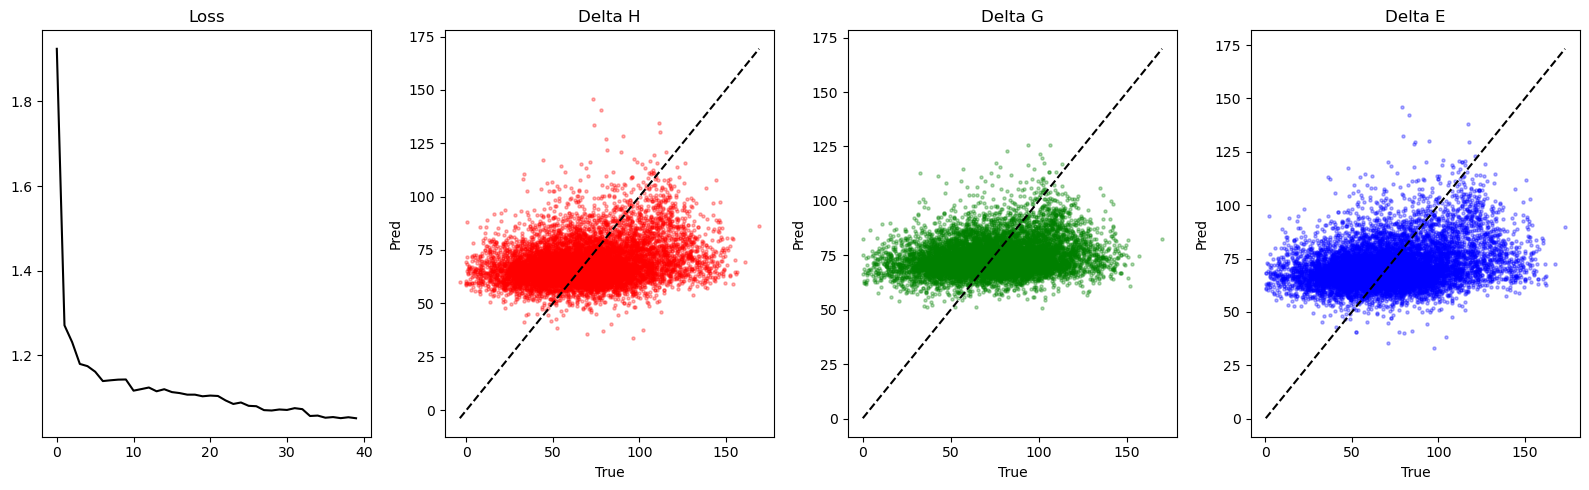

In [14]:
if __name__ == "__main__":
    import os
    # 경로 설정
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        # 1만개로 테스트
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
                plt.xlabel("True"); plt.ylabel("Pred")
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [15]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 21.8839    | 27.3927    | 750.3588   | 0.0563    
Delta G (ΔG)    | 20.8840    | 26.0502    | 678.6146   | 0.0379    
Delta E (ΔE)    | 22.4994    | 28.2022    | 795.3651   | 0.0732    
⭐ Average MAE: 21.7558 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

